In [1]:
# Import libs
import sys
import matplotlib.pyplot as plt
from docplex.mp.model import Model
from docplex.util.environment import get_environment
from docplex.mp.relax_linear import LinearRelaxer
import matplotlib.patches as mpatches

try:
    import docplex.mp
except:
    raise Exception('Please install docplex. See https://pypi.org/project/docplex/')

In [2]:
# ACEITES
A = 'A'
B = 'B'
C = 'C'
D = 'D'
E = 'E'
ACEITES = [A,B,C,D,E]
CONST_m_INDICADORAS = 0.01
CONST_M_INDICADORAS = 1000

# PRECIOS
PRECIO_ACEITE_COMESTIBLE = 150
PRECIO_ACEITE_CRUDO = {
    A: 110,
    B: 120,
    C: 130,
    D: 110,
    E: 115
}

# REFINADO
CONST_TIEMPO_REFINADO = 50 # definir

# DUREZAS
MIN_DUREZA = 3
MAX_DUREZA = 6
DUREZA_ACEITE_CRUDO = {
    A: 8.8,
    B: 6.1,
    C: 2.0,
    D: 4.2,
    E: 5.0
}

# COSTO MANTENIMIENTO
COSTO_MANTENIMIENTO = {
    1: 5000, #5000
    2: 8000, #8000
    3: 9500, #9500
    4: 10000  #10000
}
LIMITES_INTERVALOS = [0, 100, 200, 500, 500]
CANTIDAD_INTERVALOS = 4
CONST_m_COTA_INFERIOR_INTERVALO = 0.1
CONST_M_COTA_SUPERIOR_INTERVALO = 20000

# CAPACIDADES
CAPACIDAD_LINEA_AB = 200 #200
CAPACIDAD_LINEA_CDE = 250 #250

# CONSTANTE DE MEZCLA
CANTIDAD_MIN_ACEITES_EN_MEZCLA = 2
CANTIDAD_MAX_ACEITES_EN_MEZCLA = 3
MINIMO_ACEITE_CRUDO = 20

In [3]:
mdl = Model(name="Ejericicio 3.6: Aceites")

# VARIABLES DE DECISION
producto_fabricado = mdl.continuous_var(name = "producto_final")

aceite_comprado = {tipo: mdl.continuous_var(name=f'aceite_comprado_{tipo}') for tipo in ACEITES}
se_usa_aceite = {tipo: mdl.binary_var(name=f'se_usa_aceite_{tipo}') for tipo in ACEITES}

intervalo_usado = {intervalo: mdl.binary_var(name=f'intervalo_{intervalo}_usado') for intervalo in range(1, 1+CANTIDAD_INTERVALOS)}
tiempo_refinamiento_intervalo = {intervalo: mdl.continuous_var(name=f'tiempo_refinamiento_intervalo_{intervalo}') for intervalo in range(1, 1+CANTIDAD_INTERVALOS)}
tiempo_refinamiento = mdl.continuous_var(name = "tiempo_total_de_refinamiento")

# RESTRICCIONES

# DISPONIBILIDAD DE PLANTA DE PRODUCCION
mdl.add_constraint(aceite_comprado[A] + aceite_comprado[B] <= CAPACIDAD_LINEA_AB)
mdl.add_constraint(aceite_comprado[C] + aceite_comprado[D] + aceite_comprado[E] <= CAPACIDAD_LINEA_CDE)

# INDICADORAS
for tipo in ACEITES:
    mdl.add_constraint(CONST_m_INDICADORAS*se_usa_aceite[tipo] <= aceite_comprado[tipo])
    mdl.add_constraint(aceite_comprado[tipo] <= CONST_M_INDICADORAS*se_usa_aceite[tipo])

# DUREZA
mdl.add_constraint(producto_fabricado == mdl.sum(aceite_comprado[tipo] for tipo in ACEITES))

mdl.add_constraint(MIN_DUREZA*producto_fabricado <= mdl.sum(DUREZA_ACEITE_CRUDO[tipo] * aceite_comprado[tipo] for tipo in ACEITES))
mdl.add_constraint(mdl.sum(DUREZA_ACEITE_CRUDO[tipo] * aceite_comprado[tipo] for tipo in ACEITES) <= MAX_DUREZA*producto_fabricado) 


# LIMITES DE ACEITES CRUDOS EN LA MEZCLA
mdl.add_constraint(CANTIDAD_MIN_ACEITES_EN_MEZCLA <= mdl.sum(se_usa_aceite[tipo] for tipo in ACEITES))
mdl.add_constraint(CANTIDAD_MAX_ACEITES_EN_MEZCLA >= mdl.sum(se_usa_aceite[tipo] for tipo in ACEITES))

# Minimo de cada aceite crudo en mezcla si se usa
for tipo in ACEITES:
    mdl.add_constraint(aceite_comprado[tipo] >= MINIMO_ACEITE_CRUDO * se_usa_aceite[tipo])

# SI A o B entonces C
mdl.add_constraint(se_usa_aceite[A] - se_usa_aceite[C] <= 0)
mdl.add_constraint(se_usa_aceite[B] - se_usa_aceite[C] <= 0)

# COSTOS DE MANTENIMIENTO
mdl.add_constraint(tiempo_refinamiento == CONST_TIEMPO_REFINADO*producto_fabricado)
mdl.add_constraint(tiempo_refinamiento == mdl.sum(tiempo_refinamiento_intervalo[i] for i in range(1, 1+CANTIDAD_INTERVALOS)))

mdl.add_constraint(LIMITES_INTERVALOS[0] <= tiempo_refinamiento_intervalo[1])
mdl.add_constraint((LIMITES_INTERVALOS[1] - CONST_m_COTA_INFERIOR_INTERVALO) * intervalo_usado[1] >= tiempo_refinamiento_intervalo[1])

mdl.add_constraint(LIMITES_INTERVALOS[1]*intervalo_usado[2] <= tiempo_refinamiento_intervalo[2])
mdl.add_constraint((LIMITES_INTERVALOS[2] - CONST_m_COTA_INFERIOR_INTERVALO)*intervalo_usado[2] >= tiempo_refinamiento_intervalo[2])

mdl.add_constraint(LIMITES_INTERVALOS[2]*intervalo_usado[3] <= tiempo_refinamiento_intervalo[3])
mdl.add_constraint((LIMITES_INTERVALOS[3] - CONST_m_COTA_INFERIOR_INTERVALO) * intervalo_usado[3] >= tiempo_refinamiento_intervalo[3])

mdl.add_constraint(LIMITES_INTERVALOS[3]*intervalo_usado[4] <= tiempo_refinamiento_intervalo[4])
mdl.add_constraint(CONST_M_COTA_SUPERIOR_INTERVALO*intervalo_usado[4] >= tiempo_refinamiento_intervalo[4])

mdl.add_constraint(mdl.sum(intervalo_usado[intervalo] for intervalo in range(1, 1+CANTIDAD_INTERVALOS)) <= 1)


# FUNCION OBJETIVO
ganancia = PRECIO_ACEITE_COMESTIBLE*producto_fabricado
costo_aceite = mdl.sum(PRECIO_ACEITE_CRUDO[tipo] * aceite_comprado[tipo] for tipo in ACEITES)
costo_maquina = mdl.sum(intervalo_usado[intervalo] * COSTO_MANTENIMIENTO[intervalo] for intervalo in COSTO_MANTENIMIENTO.keys())
beneficio = ganancia - costo_aceite - costo_maquina
mdl.maximize(beneficio)




solution = mdl.solve()

In [4]:
# Imprimir la solución
if solution:
    print(f'BENEFICIO:')
    print(f' - {mdl.objective_value}$')
    
else:
    print("No se encontro solución.")

BENEFICIO:
 - 5600.0$


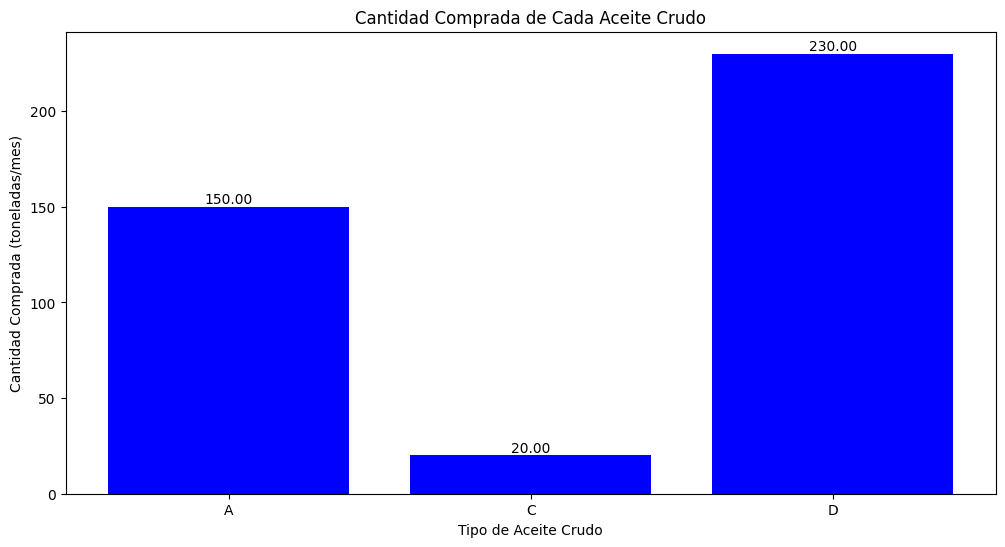

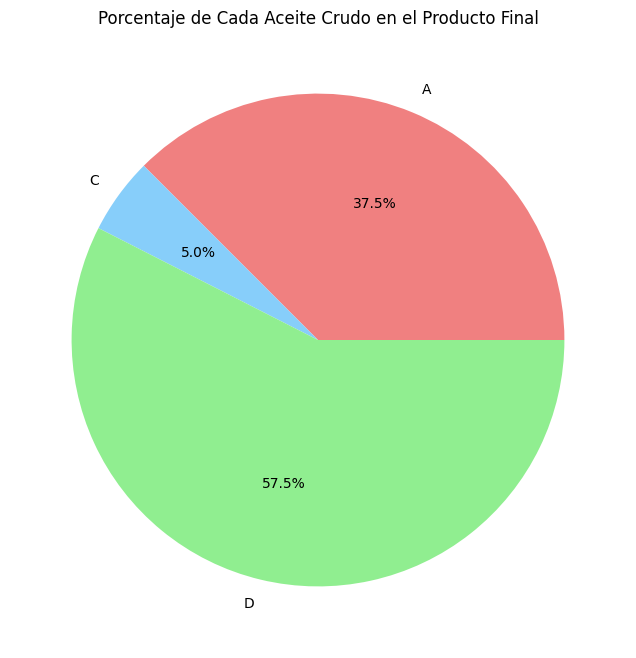

In [5]:
# Datos de solución obtenidos de tu modelo
cantidades_aceite_comprado = {tipo: aceite_comprado[tipo].solution_value for tipo in ACEITES if aceite_comprado[tipo].solution_value > 0}  # Solución de aceites comprados
producto_total = producto_fabricado.solution_value  # Solución de producto final

# Porcentaje de cada aceite respecto al producto final
porcentaje_aceites = {tipo: (cantidad / producto_total) * 100 for tipo, cantidad in cantidades_aceite_comprado.items() if cantidad > 0}

# Gráfico de barras para cantidad comprada de cada aceite crudo
plt.figure(figsize=(12, 6))
bars = plt.bar(cantidades_aceite_comprado.keys(), cantidades_aceite_comprado.values(), color='blue')
plt.xlabel('Tipo de Aceite Crudo')
plt.ylabel('Cantidad Comprada (toneladas/mes)')
plt.title('Cantidad Comprada de Cada Aceite Crudo')

# Mostrar el valor sobre cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')
plt.show()

# Gráfico de pastel para representar el porcentaje de cada aceite en el producto final
plt.figure(figsize=(8, 8))
plt.pie(porcentaje_aceites.values(), labels=porcentaje_aceites.keys(), autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue', 'lightgreen', 'gold', 'lightpink'])
plt.title('Porcentaje de Cada Aceite Crudo en el Producto Final')
plt.show()

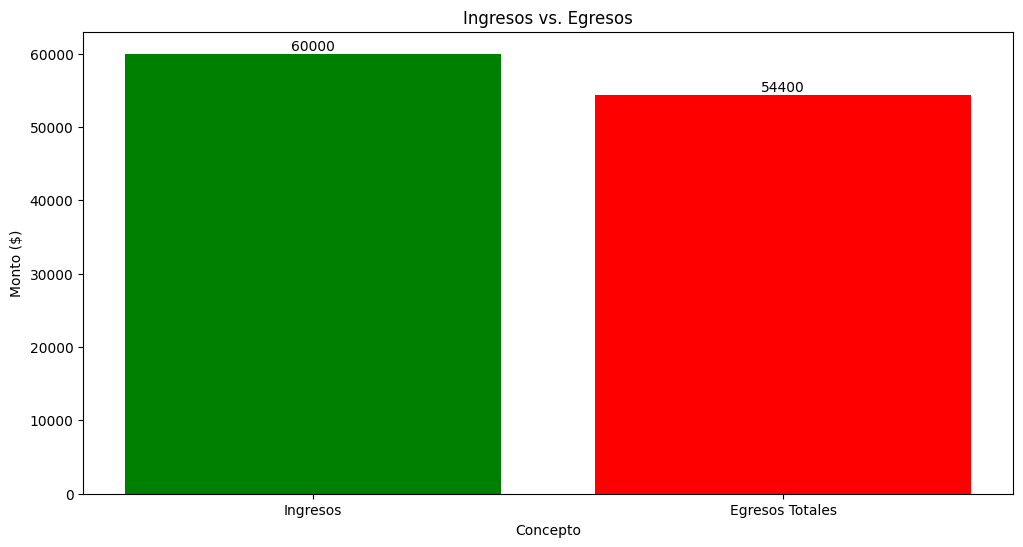

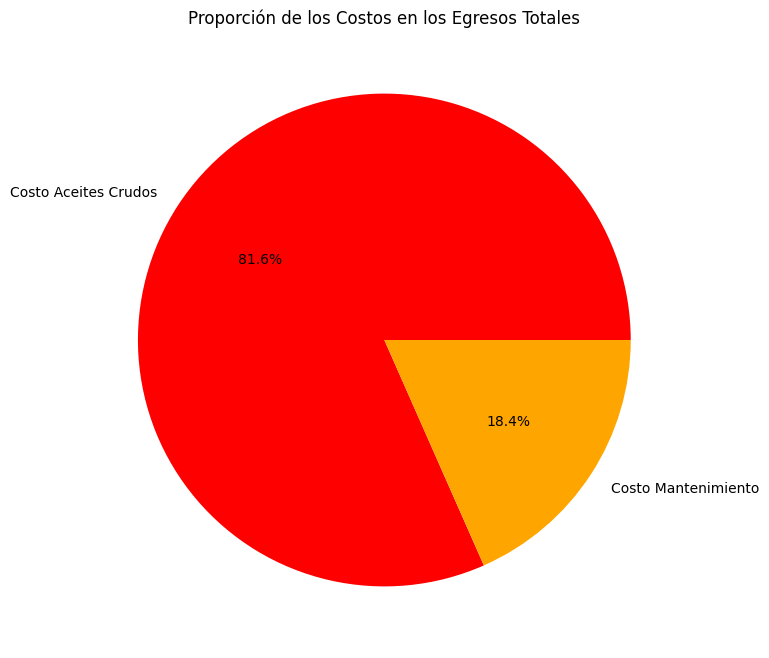

In [6]:
# Datos de ingresos y egresos obtenidos del modelo
tiempos_refinamiento = {intervalo: tiempo_refinamiento_intervalo[intervalo].solution_value for intervalo in range(1, CANTIDAD_INTERVALOS+1)}
intervalos_usados = [intervalo for intervalo, valor in intervalo_usado.items() if valor.solution_value == 1]
ingresos = PRECIO_ACEITE_COMESTIBLE * producto_total  # Ingreso por la cantidad de producto fabricado
costo_aceites = sum(PRECIO_ACEITE_CRUDO[tipo] * cantidades_aceite_comprado[tipo] for tipo in ACEITES if tipo in cantidades_aceite_comprado.keys())  # Costo total de aceites crudos comprados
costo_mantenimiento = sum(COSTO_MANTENIMIENTO[intervalo] for intervalo in intervalos_usados)  # Costo de mantenimiento de los intervalos usados
egresos_totales = costo_aceites + costo_mantenimiento  # Suma total de egresos

# Crear dataframe para organizar los datos
datos_financieros = {
    'Concepto': ['Ingresos', 'Egresos Totales'],
    'Monto': [ingresos, egresos_totales]
}

# Gráfico de barras comparativo
plt.figure(figsize=(12, 6))
bars = plt.bar(datos_financieros['Concepto'], datos_financieros['Monto'], color=['green', 'red'])
plt.xlabel('Concepto')
plt.ylabel('Monto ($)')
plt.title('Ingresos vs. Egresos')

# Mostrar el valor sobre cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.0f}', ha='center', va='bottom')
plt.show()

plt.show()

# Gráfico de pastel para representar los costos como proporción del total de egresos
costos_relativos = {'Costo Aceites Crudos': costo_aceites, 'Costo Mantenimiento': costo_mantenimiento}
plt.figure(figsize=(8, 8))
plt.pie(costos_relativos.values(), labels=costos_relativos.keys(), autopct='%1.1f%%', colors=['red', 'orange'])
plt.title('Proporción de los Costos en los Egresos Totales')
plt.show()